In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.datasets import ImageFolder 
from PIL import Image
import pandas as pd
import os
import csv
import random
from sklearn.metrics import f1_score

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('CUDA is available! Training on GPU...')
else:
    device = torch.device("cpu")
    print('CUDA is not available. Training on CPU...')

torch.cuda.empty_cache()

CUDA is available! Training on GPU...


In [5]:
train_val_path = r"..\images\train_val_images"
test_path = r"..\images\test_images"

num_classes = 17

# Load the dataset
dataset = ImageFolder(train_val_path, transform=transforms.ToTensor())

# Define the split ratio
train_ratio = 0.8
val_ratio = 0.2

# Calculate the number of samples for train and validation sets
num_train = int(len(dataset) * train_ratio)
num_val = len(dataset) - num_train

# Split the dataset
train_set, valid_set = torch.utils.data.random_split(dataset, [num_train, num_val])

# Load the test set
test_set = ImageFolder(test_path, transform=transforms.ToTensor())

# Get class names
class_names = dataset.classes

print(f"Number of training samples: {len(train_set)}")
print(f"Number of validation samples: {len(valid_set)}")
print(f"Number of test samples: {len(test_set)}")
print(f"Class names: {class_names}")


Number of training samples: 112
Number of validation samples: 28
Number of test samples: 20
Class names: ['align_engine_output', 'calibrate_distributor', 'chart_course', 'clean_o2_filter', 'clean_vent', 'clear_asteroids', 'divert_power', 'empty_garbage', 'fix_wiring', 'fuel_engines', 'inspect_sample', 'prime_shields', 'stabilize_steering', 'start_reactor', 'swipe_card', 'unlock_manifolds', 'upload_data']


In [6]:
class ResNet(nn.Module):
    def __init__(self,num_classes):
        super(ResNet, self).__init__()
        self.name = "resnetclassifier"

        # Load the pre-trained ResNet model
        resnet = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)

        # Replace the last fully connected layer
        num_features = resnet.fc.in_features
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Linear(num_features,num_classes),
            # nn.Softmax(dim=1)  #single label 
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [7]:
def get_f1_score(model, loader):
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            output = model(imgs)

            _, predicted = torch.max(output, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    #-average F1 score
    micro_f1 = f1_score(all_labels, all_predictions, average='micro')

    return micro_f1


def get_model_name(name, batch_size, learning_rate, decay_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_dr{3}_epoch{4}".format(name, batch_size, learning_rate, decay_rate, epoch)

    return path


def evaluate(model, loader, criterion):
    total_loss = 0
    i = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for imgs, labels in loader:

            imgs = imgs.cuda().to(device) # Move the input tensors to the desired device
            labels = labels.cuda().to(device)

            #labels = labels.float()
            out = model(imgs)  # forward pass
            loss = criterion(out, labels)  # compute the total loss
            total_loss += loss.item()
            i += 1

            
    model.train()  # Set the model back to training mode

    loss = float(total_loss) / (i)
    return loss

def plot_training_curve(path):
    train_acc = np.loadtxt("{}_train_acc.csv".format(path), delimiter=',')  # Specify delimiter as ','
    val_acc = np.loadtxt("{}_val_acc.csv".format(path), delimiter=',')  # Specify delimiter as ','

    plt.title("Train vs Validation Accuracy")
    n = len(train_acc)  # number of epochs
    plt.plot(range(1, n + 1), train_acc, label="Train")
    plt.plot(range(1, n + 1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [8]:
def train(model, train_set, valid_set, batch_size=1, num_epochs=5, learning_rate=1e-3, decay_rate=0.9):
    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)

    print("Length of train_loader",len(train_loader))
    print("Length of val_loader",len(val_loader))

    train_acc, val_acc, train_loss, val_loss = [], [], [], []
    i=0.0

    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0

        # Learning rate decay calculation
        current_learning_rate = learning_rate / (1 + decay_rate * epoch)

        # Update optimizer learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate

        for imgs, labels in train_loader:
            if torch.cuda.is_available():
                imgs = imgs.cuda().to(device)
                labels = labels.cuda().to(device)

            optimizer.zero_grad()
 
            out = model(imgs)
            
            loss = criterion(out, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            i+=1

        total_train_loss += loss.item()

        train_epoch_acc = get_f1_score(model, train_loader)
        train_acc.append(train_epoch_acc)

        val_epoch_acc = get_f1_score(model, val_loader)
        val_acc.append(val_epoch_acc)

        train_loss.append(total_train_loss / (i))
        val_loss.append(evaluate(model, val_loader, criterion))

        try:
            print(("Epoch {}: Train Acc: {:.4f}, Train Loss: {:.4f} | " + "Validation Acc: {:.4f}, Validation Loss: {:.4f}").format(
            epoch + 1,
            train_acc[epoch],
            train_loss[epoch],
            val_acc[epoch],
            val_loss[epoch]))
        except Exception as e:
            print("An error occurred during printing:", e)
        
        
        if(epoch % 5) == 4 or epoch == 0:
            model_path = get_model_name(model.name, batch_size, learning_rate, decay_rate, epoch)
            torch.save(model.state_dict(), model_path)
        
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    try:
        with open("{}_train_acc.csv".format(model_path), "w", newline="") as f_train_acc:
            writer_train_acc = csv.writer(f_train_acc)
            writer_train_acc.writerow(train_acc)
        with open("{}_val_acc.csv".format(model_path), "w", newline="") as f_val_acc:
            writer_val_acc = csv.writer(f_val_acc)
            writer_val_acc.writerow(val_acc)
    except Exception as e:
        print("An error occurred while saving the results:", e)

In [50]:
resnetmodel = ResNet(num_classes).cuda()
print(torch.cuda.is_available())
torch.cuda.empty_cache()

resnetmodel.train()
path_to_resnet = get_model_name("resnetclassifier",batch_size=1,learning_rate=1e-4, decay_rate=0.5, epoch=9)
train(resnetmodel,train_set, valid_set, batch_size=1, num_epochs=10, learning_rate=1e-4, decay_rate=0.5)

True
Length of train_loader 112
Length of val_loader 28
Epoch 1: Train Acc: 0.5446, Train Loss: 0.0132 | Validation Acc: 0.2857, Validation Loss: 2.8055
Epoch 2: Train Acc: 0.7321, Train Loss: 0.0116 | Validation Acc: 0.5714, Validation Loss: 2.6891
Epoch 3: Train Acc: 0.7857, Train Loss: 0.0079 | Validation Acc: 0.5714, Validation Loss: 2.6666
Epoch 4: Train Acc: 0.8214, Train Loss: 0.0045 | Validation Acc: 0.6429, Validation Loss: 2.6048
Epoch 5: Train Acc: 0.8482, Train Loss: 0.0002 | Validation Acc: 0.6429, Validation Loss: 2.5532
Epoch 6: Train Acc: 0.8929, Train Loss: 0.0032 | Validation Acc: 0.6786, Validation Loss: 2.6113
Epoch 7: Train Acc: 0.9018, Train Loss: 0.0005 | Validation Acc: 0.7143, Validation Loss: 2.6790
Epoch 8: Train Acc: 0.9018, Train Loss: 0.0015 | Validation Acc: 0.7143, Validation Loss: 2.7397
Epoch 9: Train Acc: 0.9018, Train Loss: 0.0001 | Validation Acc: 0.7143, Validation Loss: 2.9538
Epoch 10: Train Acc: 0.9018, Train Loss: 0.0001 | Validation Acc: 0.714

Length of test_loader 20
The final test accuracy of our model is: 30.0 %


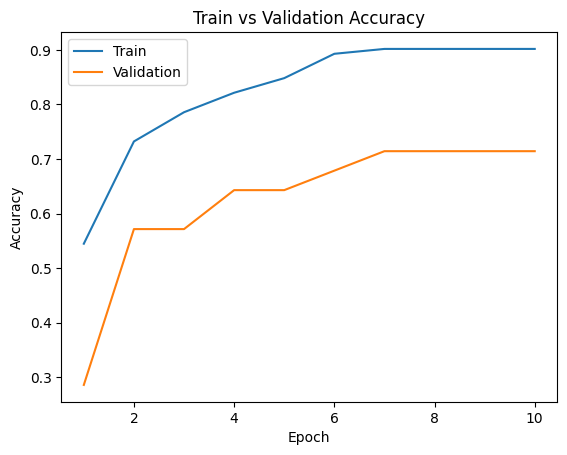

In [51]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=0)
print("Length of test_loader",len(test_loader))

resnetmodel.eval()
test_accuracy = get_f1_score(resnetmodel, test_loader)
print("The final test accuracy of our model is:", test_accuracy*100,"%")
plot_training_curve(path_to_resnet)